In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from geopy import distance
import pickle
from utils_dump_load import load_from_pickle, dump_to_pickle

<h1> EDA

<h2> Loading data

In [2]:
pickle_filename = "data/data.pkl"
df_train, df_test = load_from_pickle(pickle_filename)
df_train.shape, df_test.shape

((21201, 48), (7068, 44))

<h2> Feature Selection

In [5]:
features_not_in_test = []
for feature_name in df_train.columns:
    if feature_name not in df_test.columns:
        features_not_in_test.append(feature_name)
features_not_in_test

['Arrival at Destination - Day of Month',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Time',
 'Time from Pickup to Arrival']

In [6]:
steps = ["Placement", "Confirmation", "Arrival at Pickup", "Pickup"]

In [7]:
features_to_drop = ["Vehicle Type", "Distance (KM)", "geopy_distance"]
#option1
#features_to_drop +=  ["User Id", "Rider Id", "Pickup - Time"]
#option2
#features_to_drop += ["Pickup Lat", "Pickup Long", "Destination Lat", "Destination Long"]
#option3
features_to_drop += ['Platform Type', 'Personal or Business', "Precipitation in millimeters"]

In [8]:
for step in steps:
    #Let's keep Pickup data (last step prior run)
    if step not in ["Arrival at Destination"]:
        #features_to_drop.append(step + " - " + "Time")
        #features_to_drop.append(step + " - " + "Delta")
        features_to_drop.append(step + " - " + "Weekday (Mo = 1)")
        features_to_drop.append(step + " - Weekend")
        features_to_drop.append(step + " - " + "Day of Month")
        pass

In [9]:
features_to_drop

['Vehicle Type',
 'Distance (KM)',
 'geopy_distance',
 'Platform Type',
 'Personal or Business',
 'Precipitation in millimeters',
 'Placement - Weekday (Mo = 1)',
 'Placement - Weekend',
 'Placement - Day of Month',
 'Confirmation - Weekday (Mo = 1)',
 'Confirmation - Weekend',
 'Confirmation - Day of Month',
 'Arrival at Pickup - Weekday (Mo = 1)',
 'Arrival at Pickup - Weekend',
 'Arrival at Pickup - Day of Month',
 'Pickup - Weekday (Mo = 1)',
 'Pickup - Weekend',
 'Pickup - Day of Month']

In [10]:
to_drop = features_to_drop + features_not_in_test

<h2> Scalling data

In [11]:
features_to_scale = []
features_not_scaled = []
for feature_name in df_train.columns:
    if df_train[feature_name].dtype == np.float64 and feature_name not in to_drop:
        features_to_scale.append(feature_name)
    elif feature_name not in to_drop:
        features_not_scaled.append(feature_name)

In [12]:
features_to_scale

['Placement - Time',
 'Confirmation - Time',
 'Arrival at Pickup - Time',
 'Pickup - Time',
 'Temperature',
 'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long',
 'No_Of_Orders',
 'Age',
 'Average_Rating',
 'No_of_Ratings',
 'speed',
 'maxspeed',
 'geospeed',
 'max geospeed',
 'meanspeed',
 'max meanspeed',
 'Placement - Delta',
 'Confirmation - Delta',
 'Arrival at Pickup - Delta',
 'Distance mean']

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train[features_to_scale])
df_test_scaled = scaler.transform(df_test[features_to_scale])

In [14]:
df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=features_to_scale)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=features_to_scale)

In [15]:
df_train = pd.concat([df_train_scaled, df_train[features_not_scaled + to_drop]], axis=1)
df_test = pd.concat([df_test_scaled, df_test[features_not_scaled + features_to_drop]], axis=1)

<h2> Defining our features X and target y

In [16]:
X = df_train.drop(to_drop, axis=1)
y = df_train["Time from Pickup to Arrival"]
X.shape, y.shape

((21201, 26), (21201,))

<h1> Apply ML model

<h2> Defining X_train, X_test

In [17]:
from sklearn.model_selection import train_test_split, KFold,cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<h2> Anomaly detection

In [18]:
from sklearn.ensemble import IsolationForest
IF = IsolationForest(n_estimators=100, contamination="auto", behaviour="new", random_state=0)
y_predIF = IF.fit_predict(X)

In [19]:
y_predIF[y_predIF == 1] = 0
y_predIF[y_predIF == -1] = 1

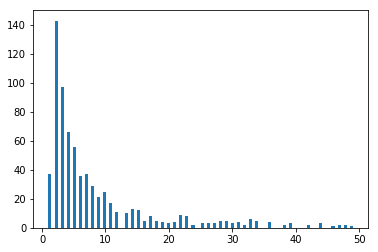

In [20]:
plt.figure()
plt.hist(y[y<50], bins=100)
plt.show()

In [21]:
y_true = np.zeros(len(y))
y_true[y<10] = 1

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predIF))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     20679
         1.0       0.23      0.35      0.28       522

   micro avg       0.95      0.95      0.95     21201
   macro avg       0.61      0.66      0.63     21201
weighted avg       0.96      0.95      0.96     21201



<h2> Benchmark model

In [23]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import HuberRegressor,SGDRegressor,ElasticNet, Ridge,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

In [24]:
def rmsle_cv(model,X_train,y_train,n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(np.mean(rmse))

In [25]:
models = [RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, LGBMRegressor, ElasticNet, 
          LinearRegression, HuberRegressor, Ridge, KNeighborsRegressor, ExtraTreesRegressor]

In [26]:
models_sel = [RandomForestRegressor, GradientBoostingRegressor, LGBMRegressor, LinearRegression, Ridge]

In [27]:
def benchmark_models():
    for Model in models_sel:
        #Model fit on full data
        model = Model()
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        err1 = rmsle_cv(model, X_train, y_train)
        err2 = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"{model_name} fit on full data :  cross val loss rmse => {err1}")
        print(f"{model_name} fit on full data :  single rmse => {err2}")

In [29]:
benchmark_models()

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor fit on full data :  cross val loss rmse => 781.6354012222861
RandomForestRegressor fit on full data :  single rmse => 776.7598493898519
GradientBoostingRegressor fit on full data :  cross val loss rmse => 728.3337368895479
GradientBoostingRegressor fit on full data :  single rmse => 723.9787320754613
LGBMRegressor fit on full data :  cross val loss rmse => 725.6378671039342
LGBMRegressor fit on full data :  single rmse => 740.3676973834733
LinearRegression fit on full data :  cross val loss rmse => 775.3978977639423
LinearRegression fit on full data :  single rmse => 770.7486113477934
Ridge fit on full data :  cross val loss rmse => 775.4124942990218
Ridge fit on full data :  single rmse => 770.5465313093104


<h2> CatBoost model

In [30]:
cat_b =  CatBoostRegressor(loss_function='RMSE', silent=True)

In [31]:
cat_b.fit(X_train, y_train)
y_pred = cat_b.predict(X_test)
print(cat_b.best_score_)
order = cat_b.feature_importances_.argsort()[::-1]
list(zip(X_train.columns[order], cat_b.feature_importances_[order]))

{'learn': {'RMSE': 676.6464243416431}}


[('Distance mean', 53.99201347981784),
 ('meanspeed', 5.807231712334879),
 ('Arrival at Pickup - Delta', 5.528476758926584),
 ('Destination Lat', 4.389661243974498),
 ('Pickup Lat', 4.010098293661921),
 ('geospeed', 3.8310301718842883),
 ('Confirmation - Delta', 3.0050494982547455),
 ('speed', 2.923919730592219),
 ('Destination Long', 2.102920240324457),
 ('Placement - Delta', 1.8668468003418184),
 ('max geospeed', 1.8361175167451271),
 ('maxspeed', 1.5615143370886881),
 ('Pickup Long', 1.4658355043528806),
 ('max meanspeed', 1.3223895096788931),
 ('Age', 0.9807028156187998),
 ('Average_Rating', 0.8978052402917196),
 ('User Id', 0.7700286981374277),
 ('No_of_Ratings', 0.7285800936871846),
 ('No_Of_Orders', 0.6983996278182165),
 ('Temperature', 0.5594668321382087),
 ('Pickup - Time', 0.3506290903263596),
 ('Placement - Time', 0.33194618722379576),
 ('Rider Id', 0.32332592114301484),
 ('Arrival at Pickup - Time', 0.3001336046290244),
 ('Confirmation - Time', 0.2898294243408793),
 ('Picku

<h1> Dump to submission file

In [32]:
X__test = df_test.drop(features_to_drop, axis=1)
X__test.shape, X_train.shape

((7068, 26), (16960, 26))

In [33]:
X__test.describe().T

,count,mean,std,min,25%,50%,75%,max
Placement - Time,7068.0,-0.012360,1.001022,-2.479172,-0.814842,-0.059424,0.777265,3.720280
Confirmation - Time,7068.0,-0.012455,1.000139,-2.424949,-0.825260,-0.058200,0.779518,3.691178
Arrival at Pickup - Time,7068.0,-0.012613,1.000647,-2.314103,-0.814995,-0.051870,0.779206,3.830805
Pickup - Time,7068.0,-0.013608,0.999891,-2.392565,-0.819158,-0.051974,0.784092,3.933809
Temperature,7068.0,-0.009555,0.996161,-2.995054,-0.708433,0.015195,0.641119,2.637986
Pickup Lat,7068.0,-0.018782,0.984852,-4.983951,-0.646787,0.005523,0.793129,4.363618
Pickup Long,7068.0,-0.003092,1.013080,-4.201462,-0.711423,-0.107936,0.492424,4.797827
Destination Lat,7068.0,0.009357,0.983148,-4.022419,-0.526672,-0.018319,0.612372,7.246856
Destination Long,7068.0,0.002378,0.972889,-3.846742,-0.551740,-0.073629,0.379588,4.645340
No_Of_Orders,7068.0,0.015632,1.034665,-1.073147,-0.735848,-0.307078,0.392929,5.122101


In [34]:
model_sel1 = GradientBoostingRegressor()
model_sel2 = LGBMRegressor()
model_sel3 = CatBoostRegressor(silent=True)

In [35]:
model_sel1.fit(X, y)
model_sel2.fit(X, y)
model_sel3.fit(X, y)

In [36]:
model_sel3.best_score_

{'learn': {'RMSE': 678.312350987965}}

In [37]:
order = model_sel3.feature_importances_.argsort()[::-1]
list(zip(X_train.columns[order], model_sel3.feature_importances_[order]))

[('Distance mean', 52.768019874917414),
 ('meanspeed', 5.814940880707042),
 ('Arrival at Pickup - Delta', 5.654774314349967),
 ('Destination Lat', 5.176597052888061),
 ('Pickup Lat', 3.601019620714619),
 ('geospeed', 3.344997910659338),
 ('speed', 3.2452908230140487),
 ('Destination Long', 2.5943889945828094),
 ('max geospeed', 2.3110828924081974),
 ('Confirmation - Delta', 2.2817070712248673),
 ('Placement - Delta', 1.872983683906858),
 ('maxspeed', 1.6615440226111806),
 ('Pickup Long', 1.6119255973070736),
 ('User Id', 1.361805817397996),
 ('max meanspeed', 1.2021412766821504),
 ('Average_Rating', 1.1920707136897264),
 ('Age', 0.8994920555571915),
 ('No_of_Ratings', 0.6615476442414312),
 ('No_Of_Orders', 0.6604006890100395),
 ('Temperature', 0.39687509890893047),
 ('Rider Id', 0.3849192585565846),
 ('Arrival at Pickup - Time', 0.35455575337022077),
 ('Confirmation - Time', 0.3255323686854965),
 ('Pickup - Time', 0.29350667623731386),
 ('Placement - Time', 0.2549020303163742),
 ('Pick

Combining Catboost output with LGBM output

In [38]:
y__pred1 = model_sel1.predict(X__test) #GradientBoosting
y__pred2 = model_sel2.predict(X__test) #LGBMRegressor
y__pred3 = model_sel3.predict(X__test) #CatBoostRegressor

y__pred = np.mean([y__pred2, y__pred3], axis=0)

In [39]:
submit_file = "data/SampleSubmission.csv"
df_submit = pd.read_csv(submit_file, index_col="Order_No")
df_submit.index = df_test.index
df_submit["Time from Pickup to Arrival"] = y__pred
df_submit.head()

,Time from Pickup to Arrival
Order No,
Order_No_19248,1652.535190
Order_No_2699,3172.234119
Order_No_21486,2020.043810
Order_No_19336,2550.397562
Order_No_20374,2954.488725


In [40]:
df_submit.to_csv("to_submit/SampleSubmission_500.csv")

<h1> to be improved

- Improve CatBoost Hyperparameters
- Implement Anomaly detection model to identify the riders who do not share the delivry distance (making speed up to 100000km/h)